In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from src.engine import DatasetTrainer
from src.metrics import cross_entropy, cross_entropy_label_logits, logistic_bregman, reverse_loss
from src.params import CPU_GENERATOR

"""
Modes for different inequality tests:
- "bg_proj": this uses the mathematically proven projection method for the Bregman divergence
- "rev_proj": this uses the reverse projection method 

Input Data Types;
- "fixed": uses [[1,1],[1,-1]]
- ("rand", tuple[int, int]): uses random +/- 1 of given shape. First element is the number of samples, second is the number of features
- ("randn", tuple[int, int]): uses random +/- 1 of given shape perturbed by small normal. First element is the number of samples, second is the number of features
"""
MODE = "rev_proj"
INPUT_DATA = ("randn", (2, 2))
# INPUT_DATA = ("randn", (10, 5))
OUT_DIM = 1
# OUT_DIM = 3
GT_WT_SCALE = 5.0

logits_to_prob = lambda x: torch.softmax(x, dim=-1) if OUT_DIM > 1 else torch.sigmoid(x)
wk_to_st_loss = {
    "bg_proj": logistic_bregman,
    "rev_proj": reverse_loss(logistic_bregman)
}

In [2]:
def model_1(x: torch.Tensor, wt: float | torch.Tensor):
    return wt * torch.prod(x, dim=-1, keepdim=True)

class Model1(nn.Module):
    def __init__(self, wt: float | torch.Tensor | None = None, out_dim: int = 1):
        super(Model1, self).__init__()
        if wt is None:
            self.weight = nn.Parameter(torch.randn(out_dim, requires_grad=True, generator=CPU_GENERATOR))
        else:
            self.weight = nn.Parameter(torch.tensor(wt, requires_grad=True))

    def forward(self, x):
        return model_1(x, self.weight[None])

def model_2(x: torch.Tensor, wt: float | torch.Tensor):
    return wt * torch.sum(x, dim=-1, keepdim=True)

class Model2(nn.Module):
    def __init__(self, wt: float | None = None, out_dim: int = 1):
        super(Model2, self).__init__()
        if wt is None:
            self.weight = nn.Parameter(torch.randn(out_dim, requires_grad=True, generator=CPU_GENERATOR))
        else:
            self.weight = nn.Parameter(torch.tensor(wt, requires_grad=True))

    def forward(self, x: torch.Tensor):
        return model_2(x, self.weight[None])


In [3]:
# input_data = torch.randn(2, 2)
if INPUT_DATA == "fixed":
    print("Using fixed input data")
    input_data = torch.tensor([[1, 1], [-1, 1]])
elif INPUT_DATA[0] == "rand":
    print(f"Using random input data of shape {INPUT_DATA}")
    input_data = 2 * torch.randint(0, 2, INPUT_DATA[1], generator=CPU_GENERATOR).float() - 1
    print(input_data.shape)
elif INPUT_DATA[0] == "randn":
    print(f"Using random perturbed input data of shape {INPUT_DATA}")
    input_data = 2 * torch.randint(0, 2, INPUT_DATA[1], generator=CPU_GENERATOR).float() - 1
    input_data += 0.5 * torch.randn(INPUT_DATA[1], generator=CPU_GENERATOR)
    print(input_data.shape)

if OUT_DIM == 1:
    gt_wt = torch.Tensor([GT_WT_SCALE])
else:
    gt_wt = GT_WT_SCALE * ((2 * torch.randint(0, 2, (OUT_DIM,), generator=CPU_GENERATOR).float() - 1) + 0.2 * torch.randn(OUT_DIM, generator=CPU_GENERATOR))
gt_model = Model1(wt=gt_wt, out_dim=OUT_DIM)
with torch.no_grad():
    labels_logits = gt_model(input_data)
    labels_probs = logits_to_prob(labels_logits)

gt_dataset = data.TensorDataset(input_data, labels_probs, labels_logits)

Using random perturbed input data of shape ('randn', (2, 2))
torch.Size([2, 2])


/tmp/ipykernel_41578/2702210829.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight = nn.Parameter(torch.tensor(wt, requires_grad=True))


In [4]:
# Some Sanity checks
print("Sanity checks")
print("Ground truth model")
print(list(gt_model.parameters()))
print("Input Data")
print(input_data)
print("Labels")
print(labels_probs)
print("Labels Logits")
print(labels_logits)

Sanity checks
Ground truth model
[Parameter containing:
tensor([5.], requires_grad=True)]
Input Data
tensor([[ 1.1629, -1.4338],
        [-0.2384, -0.6677]])
Labels
tensor([[2.3949e-04],
        [6.8911e-01]])
Labels Logits
tensor([[-8.3367],
        [ 0.7960]])


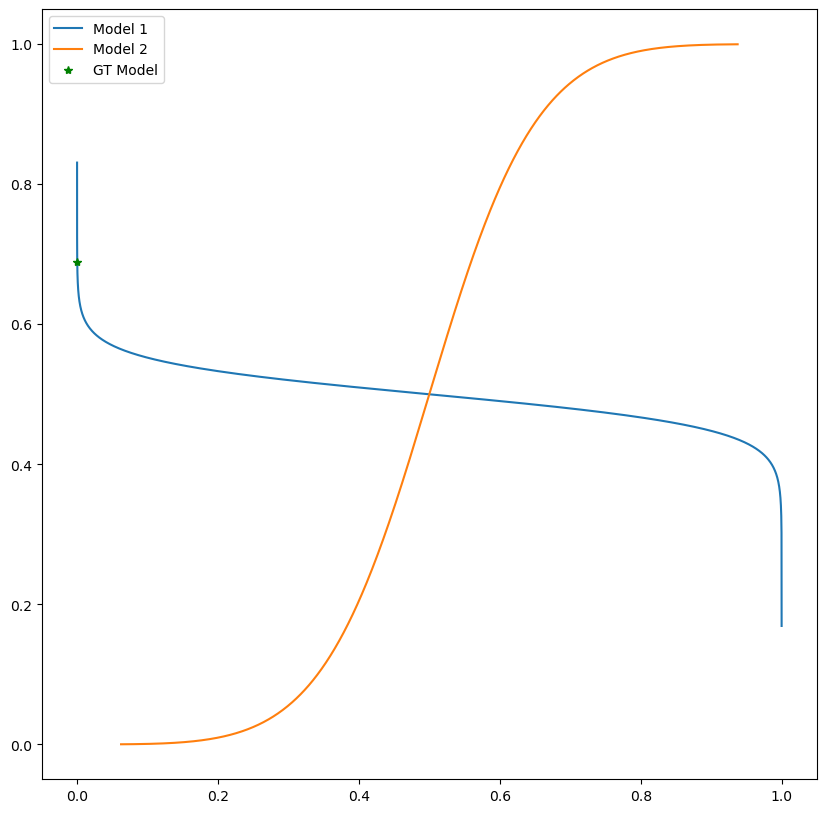

In [5]:
# Plot in primal, probability dist space
assert OUT_DIM == 1, "Only 1D output supported for plotting"
assert input_data.shape[1] == 2, "Only 2D input supported for plotting"

import matplotlib.pyplot as plt
test_points_1 = torch.linspace(-10, 10, 1000)
test_logits_1 = model_1(input_data[None], test_points_1[:, None, None])
test_probs_1 = logits_to_prob(test_logits_1).squeeze(dim=-1)

test_points_2 = torch.linspace(-10, 10, 1000)
test_logits_2 = model_2(input_data[None], test_points_2[:, None, None])
test_probs_2 = logits_to_prob(test_logits_2).squeeze(dim=-1)

plt.figure(figsize=(10, 10))
np_test_probs_1 = test_probs_1.detach().numpy()
np_test_probs_2 = test_probs_2.detach().numpy()
plt.plot(np_test_probs_1[:, 0], np_test_probs_1[:, 1], label="Model 1")
plt.plot(np_test_probs_2[:, 0], np_test_probs_2[:, 1], label="Model 2")
plt.plot(labels_probs[0, 0], labels_probs[1, 0], 'g*', label="GT Model")
plt.legend()


In [6]:
RUN_SANITY_TRAIN = False

test_model = Model1(out_dim=OUT_DIM)

if RUN_SANITY_TRAIN:
    # Sanity check train
    test_optimizer = optim.SGD(test_model.parameters(), lr=5e-1)
    test_trainer = DatasetTrainer(
        model=test_model,
        optimizer=test_optimizer,
        loss_fn=logistic_bregman,
        dataset=gt_dataset,
        use_label_logits=True
    )
    test_trainer.train(num_epochs=12000, batch_size=len(gt_dataset), update_pbar_every=100)

In [7]:
print(test_model.weight)
# This should be a constant
print(test_model.weight - gt_model.weight)

Parameter containing:
tensor([-1.0324], requires_grad=True)
tensor([-6.0324], grad_fn=<SubBackward0>)


In [8]:
TRAIN_WEAK = False
# WEAK_WEIGHTS = "rand"
WEAK_WEIGHTS = "large"

if WEAK_WEIGHTS == "rand":
    wk_model = Model2(out_dim=OUT_DIM)
elif WEAK_WEIGHTS == "large":
    assert TRAIN_WEAK == False
    if OUT_DIM == 1:
        weak_wt = torch.Tensor([9.0])
    else:
        weak_wt = 9.0 * ((2 * torch.randint(0, 2, (OUT_DIM,), generator=CPU_GENERATOR).float() - 1) + 0.2 * torch.randn(OUT_DIM, generator=CPU_GENERATOR))
    wk_model = Model2(wt=weak_wt, out_dim=OUT_DIM)


if TRAIN_WEAK:
    print("Training weak model")
    # Train the weak model
    wk_optimizer = optim.SGD(wk_model.parameters(), lr=5e-1)
    weak_trainer = DatasetTrainer(
        model=wk_model,
        optimizer=wk_optimizer,
        loss_fn=logistic_bregman,
        dataset=gt_dataset,
        use_label_logits=True
    )
    weak_trainer.train(num_epochs=7000, batch_size=len(gt_dataset))

/tmp/ipykernel_41578/2702210829.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight = nn.Parameter(torch.tensor(wt, requires_grad=True))


In [9]:
wk_model.weight

Parameter containing:
tensor([9.], requires_grad=True)

In [10]:
with torch.no_grad():
    wk_label_logits = wk_model(input_data)
    wk_labels = logits_to_prob(wk_label_logits)
wk_dataset = data.TensorDataset(input_data, wk_labels, wk_label_logits)

In [11]:
# Train the strong model against the weak
st_model = Model1(out_dim=OUT_DIM)

print("Training strong model")
print(f"Loss: {wk_to_st_loss[MODE].__name__}")
st_optimizer = optim.SGD(st_model.parameters(), lr=1e-1)
strong_trainer = DatasetTrainer(
    model=st_model,
    optimizer=st_optimizer,
    loss_fn=wk_to_st_loss[MODE],
    dataset=wk_dataset,
    use_label_logits=True
)
strong_trainer.train(num_epochs=10000, batch_size=len(wk_dataset), update_pbar_every=100)

Training strong model
Loss: reversed__logistic_bregman_binary_or__logistic_bregman_multiclass
Using model device for training: cpu
Using model device for training: cpu


100%|██████████| 10000/10000 [00:22<00:00, 452.66it/s, loss=1.86, grad_norm=2.68e-7]


In [12]:
st_model.weight

Parameter containing:
tensor([0.7684], requires_grad=True)

In [13]:
with torch.no_grad():
    st_label_logits = st_model(input_data)
    st_labels = logits_to_prob(st_label_logits)

In [14]:
# Check the inequality
if MODE == "bg_proj":
    st_gt_loss = logistic_bregman(labels_logits, st_label_logits).mean()
    wk_gt_loss = logistic_bregman(labels_logits, wk_label_logits).mean()
    wk_st_loss = logistic_bregman(st_label_logits, wk_label_logits).mean()
    ip_term = torch.mean(torch.einsum("bi,bi->b", wk_labels - st_labels, st_label_logits - labels_logits))
elif MODE == "rev_proj":
    st_gt_loss = reverse_loss(logistic_bregman)(labels_logits, st_label_logits).mean()
    wk_gt_loss = reverse_loss(logistic_bregman)(labels_logits, wk_label_logits).mean()
    wk_st_loss = reverse_loss(logistic_bregman)(st_label_logits, wk_label_logits).mean()
    ip_term = torch.mean(torch.einsum("bi,bi->b", labels_probs - st_labels, st_label_logits - wk_label_logits))

print(f"Strong vs GT: {st_gt_loss}")
print(f"Weak vs GT: {wk_gt_loss}")
print(f"Weak vs Strong: {wk_st_loss}")
misfit_ineq = wk_gt_loss - wk_st_loss - st_gt_loss
print(f"Inner Product Term: {ip_term}")
print(f"Misfit Inequality: {misfit_ineq}")

Strong vs GT: 0.14759638905525208
Weak vs GT: 2.5410804748535156
Weak vs Strong: 1.8628449440002441
Inner Product Term: 0.5306392908096313
Misfit Inequality: 0.5306391716003418


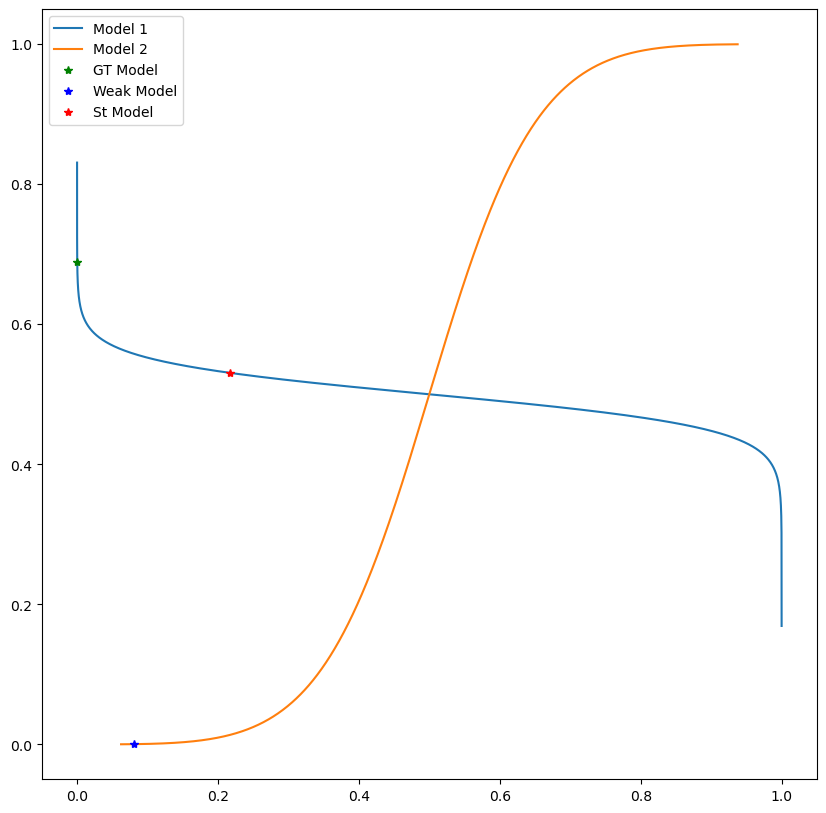

In [15]:
# Plot in primal, probability dist space
assert OUT_DIM == 1, "Only 1D output supported for plotting"
assert input_data.shape[1] == 2, "Only 2D input supported for plotting"

import matplotlib.pyplot as plt
test_points_1 = torch.linspace(-10, 10, 1000)
test_logits_1 = model_1(input_data[None], test_points_1[:, None, None])
test_probs_1 = logits_to_prob(test_logits_1).squeeze(dim=-1)

test_points_2 = torch.linspace(-10, 10, 1000)
test_logits_2 = model_2(input_data[None], test_points_2[:, None, None])
test_probs_2 = logits_to_prob(test_logits_2).squeeze(dim=-1)

plt.figure(figsize=(10, 10))
np_test_probs_1 = test_probs_1.detach().numpy()
np_test_probs_2 = test_probs_2.detach().numpy()
plt.plot(np_test_probs_1[:, 0], np_test_probs_1[:, 1], label="Model 1")
plt.plot(np_test_probs_2[:, 0], np_test_probs_2[:, 1], label="Model 2")
plt.plot(labels_probs[0, 0], labels_probs[1, 0], 'g*', label="GT Model")
plt.plot(wk_labels[0, 0], wk_labels[1, 0], 'b*', label="Weak Model")
plt.plot(st_labels[0, 0], st_labels[1, 0], 'r*', label="St Model")
plt.legend()


In [15]:
def binary_logistic_second_deriv(x):
    return torch.sigmoid(x) * (1 - torch.sigmoid(x))

def multi_logistic_second_deriv(x):
    soft = torch.softmax(x, dim=-1)
    kron = -soft[:, :, None] * soft[:, None, :]
    diag = torch.diag_embed(soft)
    return diag + kron

def logistic_second_deriv(x, out_dim: int = 1):
    if out_dim == 1:
        return binary_logistic_second_deriv(x)[:, :, None]
    else:
        return multi_logistic_second_deriv(x)

In [16]:
# Test the second derivative condition on minimization of the wk-st loss
if MODE != "rev_proj":
    print(f"Second Derivative Condition is only guaranteed to hold when reverse training is uses. MODE={MODE}")

# Make the points to test the second derivative condition on
test_points = []
for dim in range(OUT_DIM):
    test_points.append(torch.linspace(-10, 10, 100))
test_points = torch.stack(torch.meshgrid(*test_points), dim=-1).reshape(-1, OUT_DIM)
print(test_points.shape)

# Get the logits for each of the test points
test_logits = model_1(input_data[None, :, :], test_points[:, None, :])
print(test_logits.shape)

second_deriv = logistic_second_deriv(st_label_logits, OUT_DIM)
print(second_deriv.shape)

diff_term = st_label_logits - wk_label_logits
grad_term = torch.einsum("bij,bj->bi", second_deriv, diff_term)
condition_term = torch.einsum("tbi,tbi->tb", grad_term[None], test_logits)
condition = torch.mean(condition_term, dim=1)

print("Second Derivatives")
print(second_deriv)
print("Gradient Term")
print(grad_term)
print("Condition")
print(condition.shape)
print(torch.max(torch.abs(condition)))


torch.Size([100, 1])
torch.Size([100, 2, 1])
torch.Size([2, 1, 1])
Second Derivatives
tensor([[[0.1701]],

        [[0.2491]]])
Gradient Term
tensor([[-0.1968],
        [-2.0616]])
Condition
torch.Size([100])
tensor(2.6226e-06)


/home/abhmul/miniforge3/envs/pagi/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724898583682/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
# Is there a value for the test parameters that matches actual_diference
actual_difference = labels_probs - st_labels
diff_est =  torch.einsum("tbij,tbj->tbi", second_deriv[None], test_logits)
err = actual_difference - diff_est

# Look for closeness in different norms
l_inf = torch.max(torch.max(torch.abs(err), dim=2).values, dim=1).values
l_2 = torch.mean(torch.norm(err, p=2, dim=2), dim=1)
l_1 = torch.mean(torch.norm(err, p=1, dim=2), dim=1)

l_inf_idx = torch.argmin(l_inf)
l_2_idx = torch.argmin(l_2)
l_1_idx = torch.argmin(l_1)


print("Actual")
print(actual_difference)

print("L_inf")
print(l_inf[l_inf_idx])
print(test_points[l_inf_idx])
print(diff_est[l_inf_idx].round(decimals=3))
l_inf_ip_err = torch.mean(torch.einsum("bi,bi->b", err[l_inf_idx], st_label_logits - wk_label_logits))
print(l_inf_ip_err)

print("L_2")
print(l_2[l_2_idx])
print(test_points[l_2_idx])
print(diff_est[l_2_idx].round(decimals=3))
l_2_ip_err = torch.mean(torch.einsum("bi,bi->b", err[l_2_idx], st_label_logits - wk_label_logits))
print(l_2_ip_err)

print("L_1")
print(l_1[l_1_idx])
print(test_points[l_1_idx])
print(diff_est[l_1_idx].round(decimals=3))
l_1_ip_err = torch.mean(torch.einsum("bi,bi->b", err[l_1_idx], st_label_logits - wk_label_logits))
print(l_1_ip_err)


Actual
tensor([[-0.7824],
        [ 0.2197]])
L_inf
tensor(0.1035)
tensor([2.9293])
tensor([[-0.8310],
        [ 0.1160]])
tensor(-0.4564)
L_2
tensor(0.0602)
tensor([2.7273])
tensor([[-0.7730],
        [ 0.1080]])
tensor(-0.4564)
L_1
tensor(0.0602)
tensor([2.7273])
tensor([[-0.7730],
        [ 0.1080]])
tensor(-0.4564)


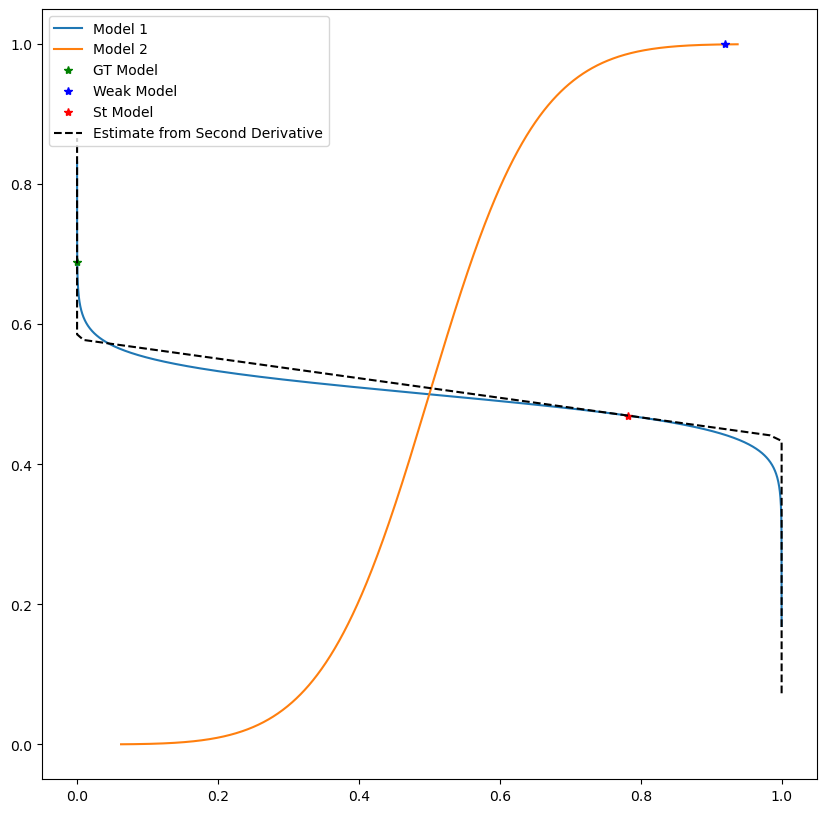

In [18]:
# Plot in primal, probability dist space
assert OUT_DIM == 1, "Only 1D output supported for plotting"
assert input_data.shape[1] == 2, "Only 2D input supported for plotting"

import matplotlib.pyplot as plt
test_points_1 = torch.linspace(-10, 10, 1000)
test_logits_1 = model_1(input_data[None], test_points_1[:, None, None])
test_probs_1 = logits_to_prob(test_logits_1).squeeze(dim=-1)

test_points_2 = torch.linspace(-10, 10, 1000)
test_logits_2 = model_2(input_data[None], test_points_2[:, None, None])
test_probs_2 = logits_to_prob(test_logits_2).squeeze(dim=-1)

plt.figure(figsize=(10,10))
np_test_probs_1 = test_probs_1.detach().numpy()
np_test_probs_2 = test_probs_2.detach().numpy()
plt.plot(np_test_probs_1[:, 0], np_test_probs_1[:, 1], label="Model 1")
plt.plot(np_test_probs_2[:, 0], np_test_probs_2[:, 1], label="Model 2")
plt.plot(labels_probs[0, 0], labels_probs[1, 0], 'g*', label="GT Model")
plt.plot(wk_labels[0, 0], wk_labels[1, 0], 'b*', label="Weak Model")
plt.plot(st_labels[0, 0], st_labels[1, 0], 'r*', label="St Model")

# Get estimate from second deriv
diff_est_approx = diff_est + st_labels[None]
diff_est_approx = torch.clip(diff_est_approx, torch.min(test_probs_1), torch.max(test_probs_1))
np_diff_est_approx = diff_est_approx.squeeze(dim=-1).detach().numpy()
plt.plot(np_diff_est_approx[:, 0], np_diff_est_approx[:, 1], 'k--', label="Estimate from Second Derivative")

plt.legend()


In [17]:
# Check how good of a local approximation is the second derivative
diff_term = labels_logits - st_label_logits
second_deriv = logistic_second_deriv(st_label_logits, OUT_DIM)
approx_difference = torch.einsum("bij,bj->bi", second_deriv, diff_term)
actual_difference = labels_probs - st_labels

print(approx_difference)
print(actual_difference)

tensor([[-0.7683, -0.6269,  1.3952],
        [ 0.3491,  0.2061, -0.5551],
        [ 0.0131,  0.0087, -0.0218],
        [-0.4854, -0.3702,  0.8557],
        [-0.7173, -0.5784,  1.2957],
        [-0.0306, -0.0207,  0.0513],
        [ 0.6011,  0.3149, -0.9160],
        [ 1.3343,  0.1874, -1.5217],
        [-1.5834, -1.5994,  3.1828],
        [ 0.8798,  0.3792, -1.2590]])
tensor([[-0.2597, -0.2826,  0.5422],
        [ 0.2188,  0.0382, -0.2570],
        [ 0.0130,  0.0084, -0.0214],
        [-0.2726, -0.2787,  0.5513],
        [-0.2638, -0.2846,  0.5484],
        [-0.0311, -0.0219,  0.0530],
        [ 0.2816, -0.0414, -0.2403],
        [ 0.4118, -0.3083, -0.1036],
        [-0.1645, -0.2050,  0.3695],
        [ 0.3377, -0.1409, -0.1968]])


In [18]:
term_2 = st_label_logits - wk_label_logits
term_1 = labels_probs - st_labels
term_1_logits = labels_logits - st_label_logits
second_deriv_term = logistic_second_deriv(st_label_logits, out_dim=OUT_DIM)

print(term_1)
print(term_1_logits)
print(term_2)
print(second_deriv_term)

print("IP Comparisons")
print("actual")
actual = torch.einsum("bi,bi->b", term_1, term_2)
print(actual)
print(actual.mean())
print("approx")
approx = torch.einsum("bij,bi,bj->b", second_deriv_term, term_1_logits, term_2)
print(approx)
print(approx.mean())

tensor([[-0.2597, -0.2826,  0.5422],
        [ 0.2188,  0.0382, -0.2570],
        [ 0.0130,  0.0084, -0.0214],
        [-0.2726, -0.2787,  0.5513],
        [-0.2638, -0.2846,  0.5484],
        [-0.0311, -0.0219,  0.0530],
        [ 0.2816, -0.0414, -0.2403],
        [ 0.4118, -0.3083, -0.1036],
        [-0.1645, -0.2050,  0.3695],
        [ 0.3377, -0.1409, -0.1968]])
tensor([[-3.7158, -2.9666,  2.3060],
        [ 1.8051,  1.4412, -1.1203],
        [ 0.0646,  0.0516, -0.0401],
        [-2.3367, -1.8656,  1.4502],
        [-3.4623, -2.7642,  2.1487],
        [-0.1509, -0.1205,  0.0937],
        [ 3.2739,  2.6138, -2.0318],
        [10.6917,  8.5359, -6.6352],
        [-9.0553, -7.2294,  5.6196],
        [ 5.2172,  4.1653, -3.2378]])
tensor([[-0.4687, -0.2408,  0.7190],
        [-1.0536, -0.7794,  0.1508],
        [-0.8775, -0.6154,  0.3332],
        [ 0.8887,  0.6765, -0.0098],
        [ 1.5848,  1.1898, -0.1191],
        [ 1.1413,  0.8019, -0.4237],
        [ 0.5627,  0.3168, -0.6919],